# Deploy a BigQuery ML user churn propensity model to Vertex AI for online predictions

## Setup

In [1]:
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 103.0 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires grpcio!=1.48.0,<2,>=1.33.1, but you have grpcio 1.48.0 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-jupyter-plugin 0.1.80 requires aiohttp~=3.9.5, but you have aiohttp 3.10.5 which is incompatible.
google-api-python-client 1.8.0 requires google-api-core<2dev,>=1.13.0, but you have google-api-core 2.23.0 which is incompatible.

**Restart the kernel and ignore the compatibility errors.**

### Define constants

In [2]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

**Note:** Replace the <code>REGION</code> with the associated region mentioned in the qwiklabs resource panel.

In [3]:
BQ_LOCATION = 'US'
REGION = 'us-central1'

### Import libraries

In [6]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd

### Create a GCS bucket for artifact storage

Create a globally unique Google Cloud Storage bucket for artifact storage. You will use this bucket to export your BQML model later in the lab and upload it to Vertex AI.

In [7]:
GCS_BUCKET = f"{PROJECT_ID}-bqmlga4"

In [8]:
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://gcp-aiml-team-bqmlga4/...


### Create a BigQuery dataset

Next, create a BigQuery dataset from this notebook using the Python-based 

This dataset will group your feature views, model, and predictions table together.

In [9]:
BQ_DATASET = f"{PROJECT_ID}:bqmlga4"

In [10]:
!bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

Dataset 'gcp-aiml-team:bqmlga4' successfully created.


### Initialize the Vertex Python SDK client

Import the Vertex SDK for Python into your Python environment and initialize it.

In [11]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

## Exploratory Data Analysis (EDA) in BigQuery

In [12]:
%%bigquery --project $PROJECT_ID

SELECT 
    *
FROM
  `firebase-public-project.analytics_153293282.events_*`
    
TABLESAMPLE SYSTEM (1 PERCENT)

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions
0,20181001,1538427584316002,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1538337928263002,NaN,1229,859722,None,8065F8E98407106A65D35195984B2258,"[{'key': 'ad_frequency', 'value': {'string_val...",1464591946544000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Oceania', 'country': 'New Zeala...","{'id': 'com.google.flood2', 'version': '2.6.31...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193347,IOS,None
1,20181001,1538427645963015,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1538427502316015,NaN,1229,859722,None,8065F8E98407106A65D35195984B2258,"[{'key': 'ad_frequency', 'value': {'string_val...",1464591946544000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Oceania', 'country': 'New Zeala...","{'id': 'com.google.flood2', 'version': '2.6.31...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193347,IOS,None
2,20181001,1538427726373002,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1538427596963002,NaN,1230,859723,None,8065F8E98407106A65D35195984B2258,"[{'key': 'ad_frequency', 'value': {'string_val...",1464591946544000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Oceania', 'country': 'New Zeala...","{'id': 'com.google.flood2', 'version': '2.6.31...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193347,IOS,None
3,20181001,1538427820322015,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1538427699373015,NaN,1230,859723,None,8065F8E98407106A65D35195984B2258,"[{'key': 'ad_frequency', 'value': {'string_val...",1464591946544000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Oceania', 'country': 'New Zeala...","{'id': 'com.google.flood2', 'version': '2.6.31...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193347,IOS,None
4,20181001,1538428010900028,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1538427800322028,NaN,1230,859723,None,8065F8E98407106A65D35195984B2258,"[{'key': 'ad_frequency', 'value': {'string_val...",1464591946544000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Oceania', 'country': 'New Zeala...","{'id': 'com.google.flood2', 'version': '2.6.31...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193347,IOS,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,20181001,1538392695476016,user_engagement,"[{'key': 'firebase_screen_class', 'value': {'s...",1538392607700016,NaN,3,246263,None,63248E747D60998BC2F157C882920CFF,"[{'key': 'first_open_time', 'value': {'string_...",1538392500139000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.google.flood2', 'version': '2.6.31...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193347,IOS,None
49996,20181001,1538392730277022,user_engagement,"[{'key': 'firebase_screen_class', 'value': {'s...",1538392676476022,NaN,3,246263,None,63248E747D60998BC2F157C882920CFF,"[{'key': 'first_open_time', 'value': {'string_...",1538392500139000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.google.flood2', 'version': '2.6.31...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193347,IOS,None
49997,20181001,1538392855525040,user_engagement,"[{'key': 'firebase_screen_class', 'value': {'s...",1538392687871040,NaN,3,246263,None,63248E747D60998BC2F157C882920CFF,"[{'key': 'first_open_time', 'value': {'string_...",1538392500139000,None,"{'category': 'mobile', 'mobile_brand_name': 'n

Note: in the cell above, Jupyterlab runs cells starting with `%%bigquery` as SQL queries. 

In [13]:
%%bigquery --project $PROJECT_ID

SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,count_distinct_users,count_events
0,15175,5700000


## Dataset preparation in BigQuery

### Defining churn for each user

In [14]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_churn AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  
SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    #add 24 hr to user's first touch
    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,
    
    #churned = 1 if last_touch within 24 hr of app installation, else 0
    IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,
    
    #bounced = 1 if last_touch within 10 min, else 0
    IF (user_last_engagement <= (user_first_engagement + 600000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement
    );

SELECT 
  * 
FROM 
  bqmlga4.user_churn 
LIMIT 100;

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,user_pseudo_id,user_first_engagement,user_last_engagement,month,julianday,dayofweek,ts_24hr_after_first_engagement,churned,bounced
0,77F5E9A5630151C9E831156AEAB4DA11,1529085265860001,1538143352338016,6,166,6,1529171665860001,0,0
1,7E40E634997585B0C69B6F67C01C191B,1528805924517015,1538571799186028,6,163,3,1528892324517015,0,0
2,343B740C7B3BD9C2CFA46BF097A8856E,1528937386654004,1538571156410062,6,165,5,1529023786654004,0,0
3,7AD772ABC639D8C0C7F1C05ECC7818F0,1528861024416001,1530374609871002,6,164,4,1528947424416001,0,0
4,6D8B6C8E0800777A88BA604FA3435B16,1529240078532006,1538288677055012,6,168,1,1529326478532006,0,0
...,...,...,...,...,...,...,...,...,...
95,64EA802089E68A699EC86438C9504F94,1529149478866010,1536019657072003,6,167,7,1529235878866010,0,0
96,BB077076D658A9593C4D36FF54402A2F,1533685366369001,1533686179782000,8,219,3,1533771766369001,1,0
97,06A302E3A4767793ADBC884143708660,1528993957895011,1538628655326000,6,165,5,1529080357895011,0,0
98,63E186D163325EF9CA8D3272059D0527,1531248046117003,1533670410230068,7,191,3,1531334446117003,0,0


Review how many of the 15k users bounced and returned below:

In [15]:
%%bigquery --project $PROJECT_ID

SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.user_churn
GROUP BY 
  bounced,
  churned
ORDER BY 
  bounced

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,bounced,churned,count_users
0,0,0,6148
1,0,1,1883
2,1,1,5557


For the training data, you will only end up using data where bounced = 0. Based on the 15k users, you can see that 5,557 ( about 41%) users bounced within the first ten minutes of their first engagement with the app. Of the remaining 8,031 users, 1,883 users ( about 23%) churned after 24 hours which you can validate with the query below:

In [16]:
%%bigquery --project $PROJECT_ID

SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    bqmlga4.user_churn
WHERE bounced = 0

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,churn_rate
0,0.234466


### Extract user demographic features

In [17]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  bqmlga4.user_demographics
LIMIT 10

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,user_pseudo_id,country,operating_system,language
0,02B38EE56B5C083073314272A03B507C,Colombia,ANDROID,es-us
1,061A7B2EE1D047BA5531AC0468C13DCC,United Kingdom,ANDROID,en-gb
2,09A826527E24EFA70A0B7A8BDCD38962,United States,ANDROID,en-us
3,0A32F2B531D2B15D8D8360E7F079E0E4,Taiwan,ANDROID,zh-tw
4,0BABA76E63C319AB6916ED97AA447408,Canada,IOS,en-ca
5,0E9150E8985138A744B88D56F015EDA7,Canada,IOS,en-ca
6,0FA8D1004780231ABD7DDA160A8CC3F1,Canada,IOS,en-ca
7,0FC4AC37E35E2B4A7A5137B1863834AE,United Kingdom,IOS,en-kw
8,119C56EBCA819C96F9370FF0C43867DA,Canada,IOS,en-ca
9,132DFC9DEB26981127A36DCB0349536D,Germany,IOS,de-de


### Aggregate user behavioral features

As a first step, you can explore all the unique events that exist in this dataset, based on event_name:

In [18]:
%%bigquery --project $PROJECT_ID

SELECT
  event_name,
  COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 
  event_name
ORDER BY
   event_count DESC

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,event_name,event_count
0,screen_view,2247623
1,user_engagement,1358958
2,level_start_quickplay,523430
3,level_end_quickplay,349729
4,post_score,242051
5,level_complete_quickplay,191088
6,level_fail_quickplay,137035
7,level_reset_quickplay,122278
8,select_content,105139
9,level_start,74417


For this lab, to predict whether a user will churn or return, you can start by counting the number of times a user engages in the following event types:

* user_engagement
* level_start_quickplay
* level_end_quickplay
* level_complete_quickplay
* level_reset_quickplay
* post_score
* spend_virtual_currency
* ad_reward
* challenge_a_friend
* completed_5_levels
* use_extra_steps

In the SQL query below, you will aggregate the behavioral data by calculating the total number of times when each of the above event_names occurred in the data set per user.

In [19]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_behavior AS (
WITH
  events_first24hr AS (
    # Select user data only from first 24 hr of using the app.
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      bqmlga4.user_churn c
    ON
      e.user_pseudo_id = c.user_pseudo_id
    WHERE
      e.event_timestamp <= c.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  user_pseudo_id
  );

SELECT
  *
FROM
  bqmlga4.user_behavior
LIMIT 10

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,user_pseudo_id,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps
0,8046473848C0E0F86B801F15D438D7A3,51,5,4,4,0,20,1,0,0,2,1
1,E236D61DE388248BC88C909A413DFFF9,1,0,0,0,0,0,0,0,0,0,0
2,C1BDCF7765C5EDD7643D476B84BD2B30,94,32,29,20,0,20,1,0,0,0,1
3,4EA76E484FE62B68F20B5175F591025A,17,6,3,3,0,3,0,0,0,0,0
4,69495B8489F605F197D1E8697BCBF02B,3,1,1,1,0,1,0,0,0,0,0
5,FAD6D4D1002F441FF9451650EE4201C2,11,4,3,1,1,1,0,0,0,0,0
6,B4F01A74A8777E282DD35AD20D8E7575,1,0,0,0,0,0,0,0,0,0,0
7,83100BA2D5053EBA42A0F7B1E790A194,22,0,0,0,0,5,0,0,0,1,0
8,64DE216C9B6E04B5EC60124BA0D79AF1,35,0,0,0,0,2,3,0,0,0,3
9,4ECE982F87221BF7A2C3642A15329244,28,6,2,0,2,2,0,0,0,0,0


### Prepare your train/eval/test datasets for machine learning

In [20]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.ml_features AS (
    
  SELECT
    dem.user_pseudo_id,
    IFNULL(dem.country, "Unknown") AS country,
    IFNULL(dem.operating_system, "Unknown") AS operating_system,
    IFNULL(REPLACE(dem.language, "-", "X"), "Unknown") AS language,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    chu.user_first_engagement,
    chu.month,
    chu.julianday,
    chu.dayofweek,
    chu.churned,
    # https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39
    # BQML Hyperparameter tuning requires STRING 3 partition data_split column.
    # 80% 'TRAIN' | 10%'EVAL' | 10% 'TEST'    
    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT(dem.user_pseudo_id), 10)) <= 7
        THEN 'TRAIN'
      WHEN ABS(MOD(FARM_FINGERPRINT(dem.user_pseudo_id), 10)) = 8
        THEN 'EVAL'
      WHEN ABS(MOD(FARM_FINGERPRINT(dem.user_pseudo_id), 10)) = 9
        THEN 'TEST'    
          ELSE '' END AS data_split
  FROM
    bqmlga4.user_churn chu
  LEFT OUTER JOIN
    bqmlga4.user_demographics dem
  ON 
    chu.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    bqmlga4.user_behavior beh
  ON
    chu.user_pseudo_id = beh.user_pseudo_id
  WHERE chu.bounced = 0
  );

SELECT
  *
FROM
  bqmlga4.ml_features
LIMIT 10

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,...,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned,data_split
0,295D9E24D8DE65A010313E667131EF19,Japan,ANDROID,jaXjp,135,5,5,2,0,20,...,0,0,1,3,1531061390779006,7,189,1,0,TRAIN
1,ACB0CC9AC2138D424084DC1D8C18F077,Brazil,ANDROID,ptXbr,77,0,0,0,0,12,...,0,0,0,0,1529814385856010,6,175,1,0,TRAIN
2,3EF8FC940E379D53BBD3FEFDAF626BB2,Japan,ANDROID,jaXjp,32,11,8,3,1,3,...,0,0,0,0,1528800580725002,6,163,3,0,TRAIN
3,E2C73393E938B51088B200E971667B8A,United States,ANDROID,enXus,11,9,3,3,4,3,...,0,0,0,0,1529555209991010,6,172,5,0,TEST
4,63056BBA77DBB061FD40BD4D66395FE7,United States,ANDROID,enXus,20,0,0,0,0,0,...,0,0,0,0,1529169912175006,6,167,7,0,TRAIN
5,DAA3F353F320A717A0C418A8205292B2,United States,ANDROID,enXus,21,8,6,0,0,4,...,0,0,0,0,1529961077825028,6,176,2,0,TRAIN
6,D7EA8E3645EFFBD6443946179ED704A6,South Korea,ANDROID,koXkr,157,84,63,0,0,62,...,0,0,0,0,1529325643563004,6,169,2,0,TRAIN
7,11A8D6037368A4C4508B11ADB4353BC4,United Kingdom,ANDROID,enXgb,9,3,2,2,0,2,...,0,0,0,0,1528914086471003,6,164,4,0,TRAIN
8,D1CC3A8740095F70116D613EC471A21D,Peru,ANDROID,enXus,5,2,1,1,0,1,...,0,0,0,0,1529704058108001,6,173,6,0,TRAIN
9,0CE0108DD168AC70E11C9DD96C122956,Chile,ANDROID,esXar,41,0,0,0,0,6,...,0,0,1,2,1532968284137001,7,211,2,0,TRAIN


### Validate feature splits

Run the query below to validate the number of examples in each data partition for the 80% train |10% eval |10% test split.

In [21]:
%%bigquery --project $PROJECT_ID

SELECT
  data_split,
  COUNT(*) AS n_examples
FROM bqmlga4.ml_features
GROUP BY data_split

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,data_split,n_examples
0,TEST,799
1,EVAL,846
2,TRAIN,6386


## Train and tune a BQML XGBoost propensity model to predict customer churn

In [22]:
MODEL_NAME="churn_xgb"

In [23]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL bqmlga4.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["churned"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6])
) AS

SELECT
  * EXCEPT(user_pseudo_id)
FROM
  bqmlga4.ml_features

Query is running:   0%|          |

""


In [24]:
%%bigquery --project $PROJECT_ID

SELECT *
FROM
  ML.TRIAL_INFO(MODEL `bqmlga4.churn_xgb`);

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6}",{'roc_auc': 0.7873576423576424},0.436812,0.461768,SUCCEEDED,None,True
1,2,"{'learn_rate': 0.08020900367749866, 'max_tree_...",{'roc_auc': 0.7713126873126873},0.463295,0.477633,SUCCEEDED,None,False
2,3,"{'learn_rate': 0.058624475545799554, 'max_tree...",{'roc_auc': 0.7808421578421578},0.470384,0.488319,SUCCEEDED,None,False
3,4,"{'learn_rate': 0.05685551945706865, 'max_tree_...",{'roc_auc': 0.7641498501498502},0.483514,0.495112,SUCCEEDED,None,False
4,5,"{'learn_rate': 0.08271510278233102, 'max_tree_...",{'roc_auc': 0.7747082917082917},0.460567,0.474055,SUCCEEDED,None,False
5,6,"{'learn_rate': 0.09250433334017724, 'max_tree_...",{'roc_auc': 0.7824155844155845},0.443583,0.468366,SUCCEEDED,None,False
6,7,"{'learn_rate': 0.1, 'max_tree_depth': 5}",{'roc_auc': 0.77594005994006},0.450466,0.465411,SUCCEEDED,None,False
7,8,"{'learn_rate': 0.08273902540497406, 'max_tree_...",{'roc_auc': 0.775016983016983},0.460539,0.473997,SUCCEEDED,None,False


## Evaluate BQML XGBoost model performance

In [25]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_xgb)
WHERE trial_id=1;

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.604167,0.148718,0.768461,0.238683,0.480936,0.767545


In [26]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_xgb)
WHERE trial_id=1;

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,585,19
1,1,166,29


In [27]:
%%bigquery df_roc --project $PROJECT_ID

SELECT * FROM ML.ROC_CURVE(MODEL bqmlga4.churn_xgb)

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

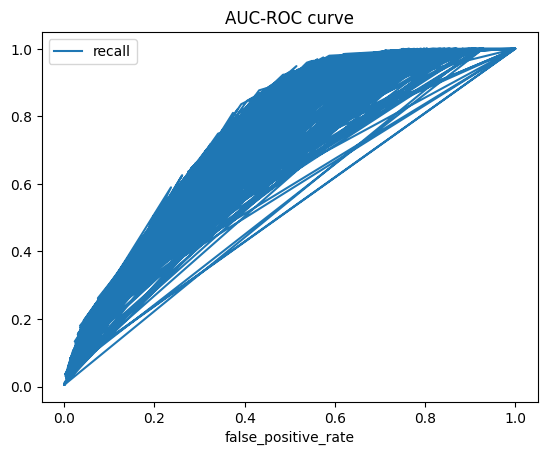

In [28]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

## Inspect global feature attributions

In [29]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL bqmlga4.churn_xgb)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,trial_id,feature,attribution
0,1,cnt_user_engagement,0.191482
1,1,user_first_engagement,0.090093
2,1,julianday,0.068122
3,1,operating_system,0.053907
4,1,cnt_post_score,0.015645
5,1,cnt_level_start_quickplay,0.014644
6,1,cnt_level_end_quickplay,0.013826
7,1,cnt_level_reset_quickplay,0.005394
8,1,language,0.005119
9,1,cnt_spend_virtual_currency,0.004703


## Generate batch predictions

In [30]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.ml_features WHERE data_split = "TEST"))

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,trial_id,predicted_churned,predicted_churned_probs,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,...,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned,data_split
0,1,0,"[{'label': 1, 'prob': 0.31426507234573364}, {'...",DABC5234774C4E18EF0B59DE32DEFD2D,United States,IOS,enXus,114,38,34,...,0,0,0,0,1535583142364013,8,241,4,0,TEST
1,1,1,"[{'label': 1, 'prob': 0.6353479027748108}, {'l...",93D1C9C170D86CF527FD6D4D46B38DC7,Japan,IOS,jaXjp,10,1,0,...,0,0,0,0,1537420280163001,9,263,5,0,TEST
2,1,0,"[{'label': 1, 'prob': 0.16598105430603027}, {'...",37DEF17DD3761C66B7F56806F978E726,United States,IOS,en,11,6,3,...,0,0,0,0,1529946580053013,6,176,2,0,TEST
3,1,0,"[{'label': 1, 'prob': 0.41147157549858093}, {'...",5B333FE2BC3875C6C3882279B51B8BAF,United States,IOS,enXus,32,5,5,...,0,0,0,0,1535417793965004,8,240,3,0,TEST
4,1,0,"[{'label': 1, 'prob': 0.18282541632652283}, {'...",EEBCB25D5F056CCF59DDE654388ACD2B,United States,IOS,enXus,12,4,3,...,0,0,0,0,1529520781166009,6,171,4,0,TEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,1,0,"[{'label': 1, 'prob': 0.30004656314849854}, {'...",37B0D1541CE3510AAEB4693829DDB671,United States,IOS,enXus,15,4,4,...,0,0,0,1,1536112281568010,9,248,4,1,TEST
795,1,0,"[{'label': 1, 'prob': 0.4321029484272003}, {'l...",8D64707940036AB6BA38D11784A7B8D8,United Kingdom,IOS,enXgb,45,1,0,...,0,0,1,3,1533386908739006,8,216,7,1,TEST
796,1,0,"[{'label': 1, 'prob': 0.426279217004776}, {'la...",4C1D5B46FCB311D0DA33E2F82BBE541E,France,IOS,enXch,31,3,2,...,0,0,0,0,1531647117819001,7,196,1,0,TEST
797,1,0,"[{'label': 1, 'prob': 0.11395689845085144}, {'...",4660CA55B6DE728FDF54308DFCBAE1D5,Brazil,ANDROID,ptXbr,1,0,0,...,0,0,0,0,1534280947526001,8,226,3,0,TEST


The following query returns the probability that the user will return after 24 hrs. The higher the probability and closer it is to 1, the more likely the user is predicted to churn, and the closer it is to 0, the more likely the user is predicted to return.

In [31]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE TABLE bqmlga4.churn_predictions AS (
SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.ml_features))
);

Query is running:   0%|          |

""


## Export a BQML model to Vertex AI for online predictions

### Export BQML model to GCS

In [32]:
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

In [33]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model $BQ_MODEL \
$BQ_MODEL_EXPORT_DIR

Waiting on bqjob_r664a9ff177a0d8a7_000001937beaab7b_1 ... (1s) Current status: DONE   


Navigate to [Google Cloud Storage](https://pantheon.corp.google.com/storage) in Google Cloud Console to `"gs://{GCS_BUCKET}/{MODEL_NAME}"`. Validate that you see your exported model assets in the below format:

```
|--/{GCS_BUCKET}/{MODEL_NAME}/
   |--/assets/                       # Contains preprocessing code.  
      |--0_categorical_label.txt     # Contains country vocabulary.
      |--1_categorical_label.txt     # Contains operating_system vocabulary.
      |--2_categorical_label.txt     # Contains language vocabulary.
      |--model_metadata.json         # contains model feature and label mappings.
   |--main.py                        # Can be called for local training runs.
   |--model.bst                      # XGBoost saved model format.
   |--xgboost_predictor-0.1.tar.gz   # Compress XGBoost model with prediction function. 
```

### Upload BQML model to Vertex AI from GCS

In [34]:
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [35]:
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/561213738755/locations/us-central1/models/8956838323653967872/operations/5567907538524962816
Model created. Resource name: projects/561213738755/locations/us-central1/models/8956838323653967872@1
To use this Model in another session:
model = aiplatform.Model('projects/561213738755/locations/us-central1/models/8956838323653967872@1')


### Deploy a Vertex `Endpoint` for online predictions

In [36]:
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="e2-standard-2",
)

Creating Endpoint
Create Endpoint backing LRO: projects/561213738755/locations/us-central1/endpoints/3939674407135346688/operations/4213449950593286144
Endpoint created. Resource name: projects/561213738755/locations/us-central1/endpoints/3939674407135346688
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/561213738755/locations/us-central1/endpoints/3939674407135346688')
Deploying model to Endpoint : projects/561213738755/locations/us-central1/endpoints/3939674407135346688
Deploy Endpoint model backing LRO: projects/561213738755/locations/us-central1/endpoints/3939674407135346688/operations/1628383764482621440
Endpoint model deployed. Resource name: projects/561213738755/locations/us-central1/endpoints/3939674407135346688


### Query model for online predictions

In [41]:
CATEGORICAL_FEATURES = ['country',
                        'operating_system',
                        'language']

In [42]:
from sklearn.preprocessing import OrdinalEncoder

In [43]:
def _build_cat_feature_encoders(cat_feature_list, gcs_bucket, model_name, na_value='Unknown'):
    """Build categorical feature encoders for mapping text to integers for XGBoost inference. 
    Args:
      cat_feature_list (list): List of string feature names.
      gcs_bucket (str): A string path to your Google Cloud Storage bucket.
      model_name (str): A string model directory in GCS where your BQML model was exported to.
      na_value (str): default is 'Unknown'. String value to replace any vocab NaN values prior to encoding.
    Returns:
      feature_encoders (dict): A dictionary containing OrdinalEncoder objects for integerizing 
        categorical features that has the format [feature] = feature encoder.
    """
    
    feature_encoders = {}
    
    for idx, feature in enumerate(cat_feature_list):
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_file = f"gs://{gcs_bucket}/{model_name}/assets/{idx}_categorical_label.txt"
        feature_vocab_df = pd.read_csv(feature_vocab_file, delimiter = "\t", header=None).fillna(na_value)
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[feature] = feature_encoder
    
    return feature_encoders

In [44]:
def preprocess_xgboost(instances, cat_feature_list, feature_encoders):
    """Transform instances to numerical values for inference.
    Args:
      instances (list[dict]): A list of feature dictionaries with the format feature: value. 
      cat_feature_list (list): A list of string feature names.
      feature_encoders (dict): A dictionary with the format feature: feature_encoder.
    Returns:
      transformed_instances (list[list]): A list of lists containing numerical feature values needed
        for Vertex XGBoost inference.
    """
    transformed_instances = []
    
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)

    return transformed_instances

In [45]:
# Build a dictionary of ordinal categorical feature encoders.
feature_encoders = _build_cat_feature_encoders(CATEGORICAL_FEATURES, GCS_BUCKET, MODEL_NAME)

In [46]:
%%bigquery test_df --project $PROJECT_ID 

SELECT* EXCEPT (user_pseudo_id, churned, data_split)
FROM bqmlga4.ml_features
WHERE data_split="TEST"
LIMIT 3;

Query is running:   0%|          |

/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

In [47]:
# Convert dataframe records to feature dictionaries for preprocessing by feature name.
test_instances = test_df.astype(str).to_dict(orient='records')

In [48]:
# Apply preprocessing to transform categorical features and return numerical instances for prediction.
transformed_test_instances = preprocess_xgboost(test_instances, CATEGORICAL_FEATURES, feature_encoders)

In [49]:
# Generate predictions from model deployed to Vertex AI Endpoint.
predictions = endpoint.predict(instances=transformed_test_instances)

In [50]:
for idx, prediction in enumerate(predictions.predictions):
    # Class labels [1,0] retrieved from model_metadata.json in GCS model dir.
    # BQML binary classification default is 0.5 with above "Churn" and below "Not Churn".
    is_churned = "Churn" if prediction[0] >= 0.5 else "Not Churn"
    print(f"Prediction: Customer {idx} - {is_churned} {prediction}")
    print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Customer 0 - Not Churn [0.1113976761698723, 0.8886023759841919]
{"country":"India","operating_system":"ANDROID","language":"enXgb","cnt_user_engagement":"25","cnt_level_start_quickplay":"12","cnt_level_end_quickplay":"0","cnt_level_complete_quickplay":"0","cnt_level_reset_quickplay":"4","cnt_post_score":"0","cnt_spend_virtual_currency":"0","cnt_ad_reward":"0","cnt_challenge_a_friend":"0","cnt_completed_5_levels":"0","cnt_use_extra_steps":"0","user_first_engagement":"1528811773465003","month":"6","julianday":"163","dayofweek":"3"}

Prediction: Customer 1 - Not Churn [0.1113976761698723, 0.8886023759841919]
{"country":"United States","operating_system":"ANDROID","language":"enXus","cnt_user_engagement":"36","cnt_level_start_quickplay":"2","cnt_level_end_quickplay":"1","cnt_level_complete_quickplay":"1","cnt_level_reset_quickplay":"0","cnt_post_score":"5","cnt_spend_virtual_currency":"2","cnt_ad_reward":"0","cnt_challenge_a_friend":"0","cnt_completed_5_levels":"0","cnt_use_ext